<a href="https://www.kaggle.com/code/zulqarnain11/acne-classification-using-cnn?scriptVersionId=267310242" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Acne Classification Using CNN
## Goal:
Build a deep learning model to classify acne types using a CNN model, while addressing dataset imbalance through oversampling and augmentation.

## ----------------------------
## 1. IMPORTS
## ----------------------------

In [ ]:

import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom, Rescaling
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import regularizers
from sklearn.utils.class_weight import compute_class_weight
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

## 📦 2. Download Dataset

In [28]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("tiswan14/acne-dataset-image")

print("Path to dataset files:", path)

# Download thêm dataset face-scar
path_scar = kagglehub.dataset_download("nayanchaure/face-scar")

print("Path to face-scar dataset files:", path_scar)

Path to dataset files: /Users/huynguyen/.cache/kagglehub/datasets/tiswan14/acne-dataset-image/versions/1
Path to face-scar dataset files: /Users/huynguyen/.cache/kagglehub/datasets/nayanchaure/face-scar/versions/1


## 📂 3. Dataset Paths & Parameters

## 📦 3.1. Kiểm tra và Merge Dataset Face-Scar


In [29]:

import shutil
from sklearn.model_selection import train_test_split

# Kiểm tra cấu trúc dataset face-scar
print("Kiểm tra cấu trúc dataset face-scar:")
scar_base = path_scar
print(f"Scar dataset path: {scar_base}")
print(f"Contents: {os.listdir(scar_base)}")

# Tìm thư mục chứa ảnh (có thể có nhiều cấu trúc khác nhau)
scar_images_dir = None
for item in os.listdir(scar_base):
    item_path = os.path.join(scar_base, item)
    if os.path.isdir(item_path):
        # Kiểm tra xem có chứa ảnh không
        files = os.listdir(item_path)
        if any(f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp')) for f in files):
            scar_images_dir = item_path
            break
        # Hoặc có thể có subdirectories là các class
        subdirs = [d for d in files if os.path.isdir(os.path.join(item_path, d))]
        if subdirs:
            scar_images_dir = item_path
            break

if scar_images_dir is None:
    # Nếu không tìm thấy, thử tìm trong các subdirectory
    for root, dirs, files in os.walk(scar_base):
        if files and any(f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp')) for f in files):
            scar_images_dir = root
            break

print(f"\nThư mục ảnh được tìm thấy: {scar_images_dir}")

# Liệt kê các class trong dataset scar (nếu có)
if scar_images_dir:
    scar_contents = os.listdir(scar_images_dir)
    print(f"\nNội dung trong thư mục: {scar_contents[:10]}...")  # Hiển thị 10 item đầu


Kiểm tra cấu trúc dataset face-scar:
Scar dataset path: /Users/huynguyen/.cache/kagglehub/datasets/nayanchaure/face-scar/versions/1
Contents: ['scar']

Thư mục ảnh được tìm thấy: /Users/huynguyen/.cache/kagglehub/datasets/nayanchaure/face-scar/versions/1/scar

Nội dung trong thư mục: ['scar1_0_4692.jpeg', 'scar1_0_3157.jpeg', 'scar1_0_7817.jpeg', 'scar1_0_4738.jpeg', 'scar1_0_7544.jpeg', 'scar1_0_3911.jpeg', 'scar1_0_2603.jpeg', 'scar1_0_104.jpeg', 'scar1_0_7051.jpeg', 'scar1_0_6640.jpeg']...


## 🔀 3.2. Merge Dataset Face-Scar vào Train/Valid/Test

In [30]:
## 🔀 3.2. Merge Dataset Face-Scar vào Train/Valid/Test

# Định nghĩa các đường dẫn dataset (cần thiết trước khi merge)
base_dir = os.path.join(path, "AcneDataset")
train_dir = os.path.join(base_dir, "train")
valid_dir = os.path.join(base_dir, "valid")
test_dir = os.path.join(base_dir, "test")

# Thu thập tất cả ảnh từ dataset scar
scar_images = []
scar_labels = []

if scar_images_dir:
    # Kiểm tra xem có cấu trúc theo class không
    subdirs = [d for d in os.listdir(scar_images_dir)
               if os.path.isdir(os.path.join(scar_images_dir, d))]

    if subdirs:
        # Có cấu trúc theo class
        print("Dataset có cấu trúc theo class:")
        for class_name in subdirs:
            class_path = os.path.join(scar_images_dir, class_name)
            images = [f for f in os.listdir(class_path)
                     if f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp'))]
            scar_images.extend([os.path.join(class_path, img) for img in images])
            scar_labels.extend([class_name] * len(images))
            print(f"  {class_name}: {len(images)} ảnh")
    else:
        # Tất cả ảnh trong một thư mục (có thể là một class duy nhất)
        print("Dataset có tất cả ảnh trong một thư mục")
        images = [f for f in os.listdir(scar_images_dir)
                 if f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp'))]
        scar_images = [os.path.join(scar_images_dir, img) for img in images]
        # Nếu dataset scar không có class, có thể map vào class phù hợp nhất
        scar_labels = ['Scar'] * len(images)
        print(f"  Tổng số ảnh: {len(images)}")

print(f"\nTổng số ảnh từ dataset scar: {len(scar_images)}")

# Phân chia dataset scar thành train/valid/test (70/15/15)
if len(scar_images) > 0:
    # Chia thành train và temp (temp sẽ chia tiếp thành valid và test)
    X_train_scar, X_temp_scar, y_train_scar, y_temp_scar = train_test_split(
        scar_images, scar_labels, test_size=0.3, random_state=42, stratify=scar_labels if len(set(scar_labels)) > 1 else None
    )

    # Chia temp thành valid và test (50/50 của 30% = 15% mỗi loại)
    X_valid_scar, X_test_scar, y_valid_scar, y_test_scar = train_test_split(
        X_temp_scar, y_temp_scar, test_size=0.5, random_state=42, stratify=y_temp_scar if len(set(y_temp_scar)) > 1 else None
    )

    print(f"\nPhân chia dataset scar:")
    print(f"  Train: {len(X_train_scar)} ảnh")
    print(f"  Valid: {len(X_valid_scar)} ảnh")
    print(f"  Test: {len(X_test_scar)} ảnh")

    # Copy ảnh vào các thư mục tương ứng
    def copy_images(image_paths, labels, target_dir):
        """Copy ảnh vào thư mục target với cấu trúc theo class"""
        for img_path, label in zip(image_paths, labels):
            # Tạo thư mục class nếu chưa có
            class_dir = os.path.join(target_dir, label)
            os.makedirs(class_dir, exist_ok=True)

            # Copy file
            filename = os.path.basename(img_path)
            dest_path = os.path.join(class_dir, filename)

            # Tránh trùng lặp tên file
            if os.path.exists(dest_path):
                name, ext = os.path.splitext(filename)
                counter = 1
                while os.path.exists(dest_path):
                    dest_path = os.path.join(class_dir, f"{name}_scar_{counter}{ext}")
                    counter += 1

            shutil.copy2(img_path, dest_path)

    print("\nĐang copy ảnh vào các thư mục train/valid/test...")
    copy_images(X_train_scar, y_train_scar, train_dir)
    copy_images(X_valid_scar, y_valid_scar, valid_dir)
    copy_images(X_test_scar, y_test_scar, test_dir)
    print("✅ Hoàn thành merge dataset!")
else:
    print("⚠️ Không tìm thấy ảnh trong dataset scar")


Dataset có tất cả ảnh trong một thư mục
  Tổng số ảnh: 1742

Tổng số ảnh từ dataset scar: 1742

Phân chia dataset scar:
  Train: 1219 ảnh
  Valid: 261 ảnh
  Test: 262 ảnh

Đang copy ảnh vào các thư mục train/valid/test...
✅ Hoàn thành merge dataset!


In [31]:
X_train_scar

['/Users/huynguyen/.cache/kagglehub/datasets/nayanchaure/face-scar/versions/1/scar/scar1_0_7902.jpeg',
 '/Users/huynguyen/.cache/kagglehub/datasets/nayanchaure/face-scar/versions/1/scar/scar1_0_5852.jpeg',
 '/Users/huynguyen/.cache/kagglehub/datasets/nayanchaure/face-scar/versions/1/scar/scar1_0_2494.jpeg',
 '/Users/huynguyen/.cache/kagglehub/datasets/nayanchaure/face-scar/versions/1/scar/scar1_0_5504.jpeg',
 '/Users/huynguyen/.cache/kagglehub/datasets/nayanchaure/face-scar/versions/1/scar/scar1_0_3500.jpeg',
 '/Users/huynguyen/.cache/kagglehub/datasets/nayanchaure/face-scar/versions/1/scar/scar1_0_4744.jpeg',
 '/Users/huynguyen/.cache/kagglehub/datasets/nayanchaure/face-scar/versions/1/scar/scar1_0_5855.jpeg',
 '/Users/huynguyen/.cache/kagglehub/datasets/nayanchaure/face-scar/versions/1/scar/scar1_0_1318.jpeg',
 '/Users/huynguyen/.cache/kagglehub/datasets/nayanchaure/face-scar/versions/1/scar/scar1_0_2031.jpeg',
 '/Users/huynguyen/.cache/kagglehub/datasets/nayanchaure/face-scar/versio

In [32]:
## 📊 3.3. Kiểm tra lại số lượng ảnh sau khi merge

print("Số lượng ảnh sau khi merge dataset scar:\n")
for folder in ['train', 'valid', 'test']:
    folder_path = os.path.join(base_dir, folder)
    print(f"{folder.upper()}:")
    total = 0
    for cls in sorted(os.listdir(folder_path)):
        cls_path = os.path.join(folder_path, cls)
        if os.path.isdir(cls_path):
            count = len([f for f in os.listdir(cls_path)
                        if f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp'))])
            print(f"  {cls}: {count} ảnh")
            total += count
    print(f"  Tổng: {total} ảnh\n")


Số lượng ảnh sau khi merge dataset scar:

TRAIN:
  Blackheads: 735 ảnh
  Cyst: 645 ảnh
  Papules: 621 ảnh
  Pustules: 584 ảnh
  Scar: 4876 ảnh
  Whiteheads: 193 ảnh
  Tổng: 7654 ảnh

VALID:
  Blackheads: 240 ảnh
  Cyst: 206 ảnh
  Papules: 209 ảnh
  Pustules: 217 ảnh
  Scar: 1044 ảnh
  Whiteheads: 49 ảnh
  Tổng: 1965 ảnh

TEST:
  Blackheads: 265 ảnh
  Cyst: 189 ảnh
  Papules: 202 ảnh
  Pustules: 205 ảnh
  Scar: 1048 ảnh
  Whiteheads: 57 ảnh
  Tổng: 1966 ảnh



In [33]:
train_dir

'/Users/huynguyen/.cache/kagglehub/datasets/tiswan14/acne-dataset-image/versions/1/AcneDataset/train'

## 🧠 4. Load Datasets

In [ ]:

# ----------------------------
# PARAMETERS
# ----------------------------
BATCH_SIZE = 32
IMAGE_SIZE = 128

# ----------------------------
# LOAD DATASETS
# ----------------------------
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir, label_mode='int', image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE, shuffle=True
)

valid_ds = tf.keras.preprocessing.image_dataset_from_directory(
    valid_dir, label_mode='int', image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE, shuffle=False
)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir, label_mode='int', image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE, shuffle=False
)

class_names = train_ds.class_names
print("Classes:", class_names)



Found 7654 files belonging to 6 classes.
Found 1965 files belonging to 6 classes.
Found 1966 files belonging to 6 classes.
Classes: ['Blackheads', 'Cyst', 'Papules', 'Pustules', 'Scar', 'Whiteheads']


## 🖼️ 5. Visualize Sample Images



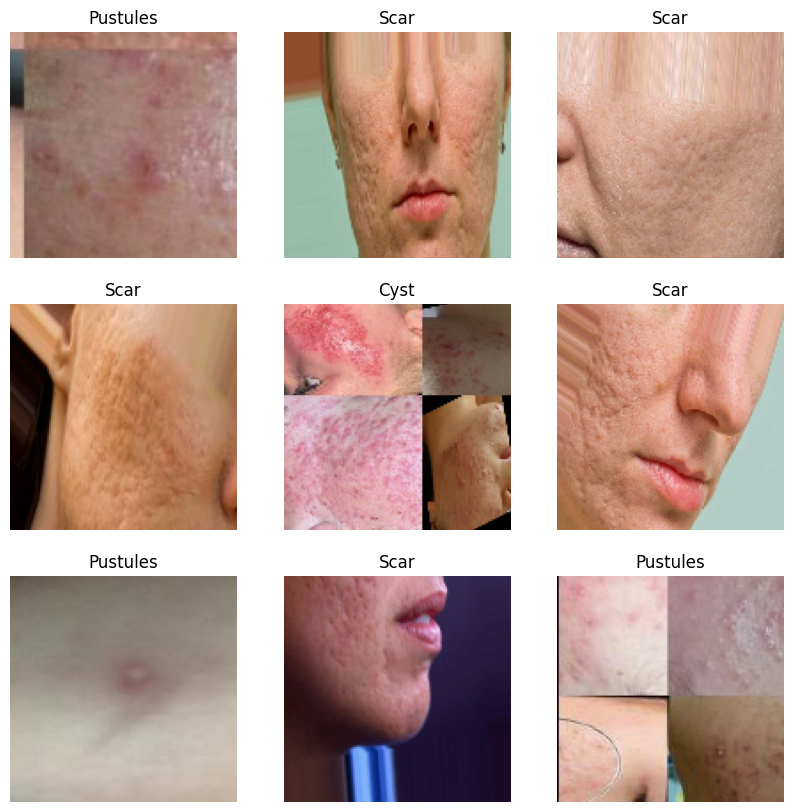

In [35]:

for image, label in train_ds.take(1):
    plt.figure(figsize=(10, 10))
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(image[i].numpy().astype("uint8"))

        label_index = label[i].numpy()
        plt.title(class_names[label_index])

        plt.axis("off")


## 📊 6. Class Distribution

In [36]:
for folder in ['train', 'valid', 'test']:
    folder_path = os.path.join(base_dir, folder)
    for cls in os.listdir(folder_path):
        cls_path = os.path.join(folder_path, cls)
        if os.path.isdir(cls_path):  # Only count directories
            print(f"{folder}/{cls}:", len(os.listdir(cls_path)))

train/Whiteheads: 193
train/Papules: 621
train/Pustules: 584
train/Cyst: 645
train/Scar: 4876
train/Blackheads: 735
valid/Whiteheads: 49
valid/Papules: 209
valid/Pustules: 217
valid/Cyst: 206
valid/Scar: 1044
valid/Blackheads: 240
test/Whiteheads: 57
test/Papules: 202
test/Pustules: 205
test/Cyst: 189
test/Scar: 1048
test/Blackheads: 265


### 📌 Observation:
Whiteheads (193 images) are underrepresented, which can bias the model.
We'll fix this using oversampling and augmentation.

## ⚖️ 7. Compute Class Weights

In [37]:
# Tính class weights tự động từ dataset thực tế sau khi merge
# Đếm số lượng ảnh trong mỗi class từ train_dir
counts = []
for cls in sorted(class_names):
    cls_path = os.path.join(train_dir, cls)
    if os.path.isdir(cls_path):
        count = len([f for f in os.listdir(cls_path) 
                    if f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp'))])
        counts.append(count)

print("Số lượng ảnh mỗi class:", dict(zip(class_names, counts)))

# Tính class weights
classes = np.array(range(len(class_names)))
y = np.repeat(classes, counts)
class_weight_dict = dict(zip(classes, compute_class_weight('balanced', classes=classes, y=y)))
print("\nClass weights:", class_weight_dict)



Số lượng ảnh mỗi class: {'Blackheads': 735, 'Cyst': 645, 'Papules': 621, 'Pustules': 584, 'Scar': 4876, 'Whiteheads': 193}

Class weights: {np.int64(0): np.float64(1.7356009070294784), np.int64(1): np.float64(1.9777777777777779), np.int64(2): np.float64(2.0542136339237786), np.int64(3): np.float64(2.1843607305936072), np.int64(4): np.float64(0.2616215477167077), np.int64(5): np.float64(6.609671848013817)}


## 🔧 8. Preprocessing & Normalization

In [38]:
normalization_layer = Rescaling(1./255)

train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
valid_ds = valid_ds.map(lambda x, y: (normalization_layer(x), y))
test_ds = test_ds.map(lambda x, y: (normalization_layer(x), y))

## 🔁 9. Data Augmentation

In [39]:
data_augmentation = Sequential([
    RandomFlip("horizontal_and_vertical"),
    RandomRotation(0.15),
    RandomZoom(0.15)
])


## 🔄 10. Oversampling Minority Class (Whiteheads)

In [ ]:
# Unbatch the dataset
train_ds_unbatched = train_ds.unbatch()

# Split dataset by class
class_datasets = []
for i in range(len(class_names)):
    class_datasets.append(train_ds_unbatched.filter(lambda x, y: y==i))

# Tìm minority class (class có số lượng ảnh ít nhất)
target_count = max(counts)
minority_index = np.argmin(counts)
minority_class_name = class_names[minority_index]
print(f"Minority class: {minority_class_name} (index {minority_index}) với {counts[minority_index]} ảnh")
print(f"Target count (max): {target_count} ảnh")

# Oversample minority class
repeat_times = target_count // counts[minority_index]
remainder = target_count % counts[minority_index]

oversampled_class = class_datasets[minority_index].repeat(repeat_times)
oversampled_class = oversampled_class.concatenate(class_datasets[minority_index].take(remainder))
class_datasets[minority_index] = oversampled_class

# Combine all classes
balanced_ds = class_datasets[0]
for ds in class_datasets[1:]:
    balanced_ds = balanced_ds.concatenate(ds)

# Shuffle, augment, and batch correctly
balanced_ds = balanced_ds.shuffle(5000)
balanced_ds = balanced_ds.map(lambda x, y: (data_augmentation(x, training=True), y))
balanced_ds = balanced_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

Minority class: Whiteheads (index 5) với 193 ảnh
Target count (max): 4876 ảnh


### ✅ Result: 
The dataset is now balanced across all acne types.

In [41]:
valid_ds = valid_ds.cache().prefetch(tf.data.AUTOTUNE)
test_ds  = test_ds.cache().prefetch(tf.data.AUTOTUNE)

## 🧰 11. Build CNN Model

In [ ]:
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(IMAGE_SIZE, IMAGE_SIZE,3)),
    MaxPooling2D(2,2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(256, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    Dropout(0.5),
    Dense(len(class_names), activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()



Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)               │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 12, 12, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 4, 4, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 2, 2, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 667,974 (2.55 MB)

 Trainable params: 667,974 (2.55 MB)

 Non-trainable params: 0 (0.00 B)

## 🏋️‍♂️ 12. Train Model


In [ ]:
# ----------------------------
# CALLBACKS
# ----------------------------
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1)

# ----------------------------
# TRAIN MODEL
# ----------------------------
history = model.fit(
    balanced_ds,
    validation_data=valid_ds,
    epochs=50,
    class_weight=class_weight_dict,
    callbacks=[early_stop, lr_scheduler],
    verbose=2
)

Epoch 1/50


2025-12-12 20:58:25.778643: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


386/386 - 104s - 269ms/step - accuracy: 0.4508 - loss: 1.8326 - val_accuracy: 0.0504 - val_loss: 3.4290 - learning_rate: 0.0010
Epoch 2/50


2025-12-12 20:58:38.165527: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:90: Filling up shuffle buffer (this may take a while): 4516 of 5000
2025-12-12 20:58:38.366256: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:483] Shuffle buffer filled.


386/386 - 105s - 273ms/step - accuracy: 0.4549 - loss: 1.6279 - val_accuracy: 0.0794 - val_loss: 3.3304 - learning_rate: 0.0010
Epoch 3/50


2025-12-12 21:00:23.544511: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:90: Filling up shuffle buffer (this may take a while): 4596 of 5000
2025-12-12 21:00:23.742283: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:483] Shuffle buffer filled.


386/386 - 100s - 259ms/step - accuracy: 0.4515 - loss: 1.4955 - val_accuracy: 0.0779 - val_loss: 2.6648 - learning_rate: 0.0010
Epoch 4/50
386/386 - 102s - 265ms/step - accuracy: 0.4440 - loss: 1.4963 - val_accuracy: 0.0768 - val_loss: 2.9131 - learning_rate: 0.0010
Epoch 5/50


2025-12-12 21:05:22.411475: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


386/386 - 108s - 281ms/step - accuracy: 0.4767 - loss: 1.4268 - val_accuracy: 0.0809 - val_loss: 2.6432 - learning_rate: 0.0010
Epoch 6/50
386/386 - 101s - 261ms/step - accuracy: 0.4718 - loss: 1.3482 - val_accuracy: 0.0850 - val_loss: 2.5803 - learning_rate: 0.0010
Epoch 7/50
386/386 - 107s - 277ms/step - accuracy: 0.5027 - loss: 1.2671 - val_accuracy: 0.0906 - val_loss: 2.3791 - learning_rate: 0.0010
Epoch 8/50
386/386 - 97s - 252ms/step - accuracy: 0.5623 - loss: 1.2104 - val_accuracy: 0.2178 - val_loss: 2.4025 - learning_rate: 0.0010
Epoch 9/50
386/386 - 98s - 255ms/step - accuracy: 0.6430 - loss: 1.1557 - val_accuracy: 0.3435 - val_loss: 2.0391 - learning_rate: 0.0010
Epoch 10/50
386/386 - 103s - 267ms/step - accuracy: 0.6393 - loss: 1.1408 - val_accuracy: 0.4061 - val_loss: 2.1362 - learning_rate: 0.0010
Epoch 11/50


2025-12-12 21:14:00.862515: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:90: Filling up shuffle buffer (this may take a while): 2122 of 5000
2025-12-12 21:14:03.840928: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:483] Shuffle buffer filled.


386/386 - 108s - 279ms/step - accuracy: 0.6645 - loss: 1.0984 - val_accuracy: 0.4468 - val_loss: 1.7864 - learning_rate: 0.0010
Epoch 12/50


2025-12-12 21:15:48.406643: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:90: Filling up shuffle buffer (this may take a while): 2212 of 5000
2025-12-12 21:15:51.044514: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:483] Shuffle buffer filled.


386/386 - 105s - 273ms/step - accuracy: 0.6960 - loss: 1.0411 - val_accuracy: 0.4504 - val_loss: 1.8246 - learning_rate: 0.0010
Epoch 13/50


2025-12-12 21:18:58.172191: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


386/386 - 96s - 249ms/step - accuracy: 0.6981 - loss: 1.0403 - val_accuracy: 0.5018 - val_loss: 1.5881 - learning_rate: 0.0010
Epoch 14/50


2025-12-12 21:19:09.957940: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:90: Filling up shuffle buffer (this may take a while): 2541 of 5000
2025-12-12 21:19:12.071005: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:483] Shuffle buffer filled.


386/386 - 128s - 332ms/step - accuracy: 0.7044 - loss: 1.0211 - val_accuracy: 0.5053 - val_loss: 1.4709 - learning_rate: 0.0010
Epoch 15/50


2025-12-12 21:21:18.092635: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:90: Filling up shuffle buffer (this may take a while): 2235 of 5000
2025-12-12 21:21:20.545045: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:483] Shuffle buffer filled.


386/386 - 104s - 271ms/step - accuracy: 0.7186 - loss: 0.9797 - val_accuracy: 0.5242 - val_loss: 1.4526 - learning_rate: 0.0010
Epoch 16/50
386/386 - 103s - 268ms/step - accuracy: 0.7208 - loss: 0.9595 - val_accuracy: 0.5288 - val_loss: 1.4277 - learning_rate: 0.0010
Epoch 17/50
386/386 - 105s - 273ms/step - accuracy: 0.7336 - loss: 0.9216 - val_accuracy: 0.5211 - val_loss: 1.3627 - learning_rate: 0.0010
Epoch 18/50


2025-12-12 21:26:31.352895: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:90: Filling up shuffle buffer (this may take a while): 3373 of 5000
2025-12-12 21:26:32.148244: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:483] Shuffle buffer filled.


386/386 - 110s - 285ms/step - accuracy: 0.7323 - loss: 0.9273 - val_accuracy: 0.5130 - val_loss: 1.4692 - learning_rate: 0.0010
Epoch 19/50


2025-12-12 21:28:21.340814: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:90: Filling up shuffle buffer (this may take a while): 3716 of 5000
2025-12-12 21:28:21.928286: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:483] Shuffle buffer filled.


386/386 - 103s - 268ms/step - accuracy: 0.7432 - loss: 0.9046 - val_accuracy: 0.5766 - val_loss: 1.1782 - learning_rate: 0.0010
Epoch 20/50
386/386 - 96s - 249ms/step - accuracy: 0.7530 - loss: 0.8625 - val_accuracy: 0.5822 - val_loss: 1.1919 - learning_rate: 0.0010
Epoch 21/50
386/386 - 98s - 253ms/step - accuracy: 0.7546 - loss: 0.8607 - val_accuracy: 0.5807 - val_loss: 1.2104 - learning_rate: 0.0010
Epoch 22/50


2025-12-12 21:33:18.820919: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:90: Filling up shuffle buffer (this may take a while): 3762 of 5000
2025-12-12 21:33:19.274656: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:483] Shuffle buffer filled.



Epoch 22: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
386/386 - 102s - 264ms/step - accuracy: 0.7628 - loss: 0.8401 - val_accuracy: 0.5766 - val_loss: 1.2177 - learning_rate: 0.0010
Epoch 23/50


2025-12-12 21:35:00.794950: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:90: Filling up shuffle buffer (this may take a while): 3633 of 5000
2025-12-12 21:35:01.533747: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:483] Shuffle buffer filled.


386/386 - 102s - 263ms/step - accuracy: 0.7779 - loss: 0.7851 - val_accuracy: 0.6122 - val_loss: 1.1059 - learning_rate: 5.0000e-04
Epoch 24/50
386/386 - 97s - 252ms/step - accuracy: 0.7858 - loss: 0.7671 - val_accuracy: 0.6300 - val_loss: 1.0383 - learning_rate: 5.0000e-04
Epoch 25/50
386/386 - 102s - 265ms/step - accuracy: 0.7872 - loss: 0.7643 - val_accuracy: 0.6010 - val_loss: 1.1966 - learning_rate: 5.0000e-04
Epoch 26/50
386/386 - 97s - 252ms/step - accuracy: 0.7987 - loss: 0.7266 - val_accuracy: 0.6631 - val_loss: 0.9479 - learning_rate: 5.0000e-04
Epoch 27/50
386/386 - 98s - 254ms/step - accuracy: 0.8031 - loss: 0.7197 - val_accuracy: 0.6631 - val_loss: 0.9226 - learning_rate: 5.0000e-04
Epoch 28/50
386/386 - 98s - 255ms/step - accuracy: 0.8031 - loss: 0.7147 - val_accuracy: 0.6646 - val_loss: 0.9075 - learning_rate: 5.0000e-04
Epoch 29/50


2025-12-12 21:46:21.936978: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


386/386 - 98s - 253ms/step - accuracy: 0.8100 - loss: 0.7098 - val_accuracy: 0.6921 - val_loss: 0.9039 - learning_rate: 5.0000e-04
Epoch 30/50
386/386 - 105s - 272ms/step - accuracy: 0.8125 - loss: 0.6979 - val_accuracy: 0.6667 - val_loss: 0.9322 - learning_rate: 5.0000e-04
Epoch 31/50
386/386 - 99s - 256ms/step - accuracy: 0.8266 - loss: 0.6514 - val_accuracy: 0.7196 - val_loss: 0.7811 - learning_rate: 5.0000e-04
Epoch 32/50
386/386 - 102s - 263ms/step - accuracy: 0.8114 - loss: 0.6909 - val_accuracy: 0.6830 - val_loss: 1.0121 - learning_rate: 5.0000e-04
Epoch 33/50
386/386 - 97s - 252ms/step - accuracy: 0.8161 - loss: 0.6607 - val_accuracy: 0.7237 - val_loss: 0.7860 - learning_rate: 5.0000e-04
Epoch 34/50

Epoch 34: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
386/386 - 98s - 254ms/step - accuracy: 0.8255 - loss: 0.6593 - val_accuracy: 0.6962 - val_loss: 0.8495 - learning_rate: 5.0000e-04
Epoch 35/50


2025-12-12 21:54:54.626802: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:90: Filling up shuffle buffer (this may take a while): 2733 of 5000
2025-12-12 21:54:55.658169: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:483] Shuffle buffer filled.


386/386 - 101s - 261ms/step - accuracy: 0.8340 - loss: 0.6140 - val_accuracy: 0.7496 - val_loss: 0.7435 - learning_rate: 2.5000e-04
Epoch 36/50
386/386 - 101s - 261ms/step - accuracy: 0.8461 - loss: 0.5940 - val_accuracy: 0.7527 - val_loss: 0.7309 - learning_rate: 2.5000e-04
Epoch 37/50
386/386 - 99s - 258ms/step - accuracy: 0.8422 - loss: 0.5867 - val_accuracy: 0.7445 - val_loss: 0.7043 - learning_rate: 2.5000e-04
Epoch 38/50
386/386 - 105s - 273ms/step - accuracy: 0.8546 - loss: 0.5708 - val_accuracy: 0.7522 - val_loss: 0.6913 - learning_rate: 2.5000e-04
Epoch 39/50
386/386 - 101s - 262ms/step - accuracy: 0.8513 - loss: 0.5765 - val_accuracy: 0.7303 - val_loss: 0.7447 - learning_rate: 2.5000e-04
Epoch 40/50
386/386 - 95s - 245ms/step - accuracy: 0.8549 - loss: 0.5633 - val_accuracy: 0.7552 - val_loss: 0.6597 - learning_rate: 2.5000e-04
Epoch 41/50


2025-12-12 22:04:56.461275: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:90: Filling up shuffle buffer (this may take a while): 4189 of 5000
2025-12-12 22:04:56.809025: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:483] Shuffle buffer filled.


386/386 - 94s - 244ms/step - accuracy: 0.8543 - loss: 0.5761 - val_accuracy: 0.7700 - val_loss: 0.6742 - learning_rate: 2.5000e-04
Epoch 42/50
386/386 - 105s - 272ms/step - accuracy: 0.8611 - loss: 0.5513 - val_accuracy: 0.7644 - val_loss: 0.6404 - learning_rate: 2.5000e-04
Epoch 43/50
386/386 - 100s - 260ms/step - accuracy: 0.8579 - loss: 0.5746 - val_accuracy: 0.7374 - val_loss: 0.7190 - learning_rate: 2.5000e-04
Epoch 44/50
386/386 - 96s - 249ms/step - accuracy: 0.8593 - loss: 0.5618 - val_accuracy: 0.7522 - val_loss: 0.6820 - learning_rate: 2.5000e-04
Epoch 45/50

Epoch 45: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
386/386 - 99s - 256ms/step - accuracy: 0.8637 - loss: 0.5394 - val_accuracy: 0.7557 - val_loss: 0.6931 - learning_rate: 2.5000e-04
Epoch 46/50
386/386 - 103s - 266ms/step - accuracy: 0.8678 - loss: 0.5254 - val_accuracy: 0.7679 - val_loss: 0.6457 - learning_rate: 1.2500e-04
Epoch 47/50
386/386 - 96s - 249ms/step - accuracy: 0.8730 - loss: 0.5097 

## 📈 13. Evaluate Model

In [55]:
test_loss, test_acc = model.evaluate(test_ds)
print("Test Accuracy:", test_acc)

62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.7426 - loss: 0.6805
Test Accuracy: 0.7426246404647827


## 🔍 14. Confusion Matrix & Classification Report

In [56]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Get true and predicted labels for test set
y_true = []
y_pred = []

for images, labels in test_ds:
    preds = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━

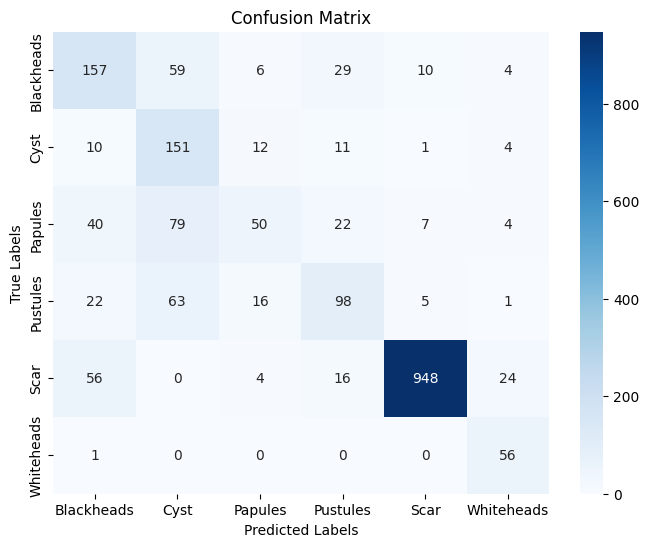

In [57]:
# ----------------------------
# CONFUSION MATRIX
# ----------------------------
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()



In [58]:
# ----------------------------
# CLASSIFICATION REPORT
# ----------------------------
report = classification_report(y_true, y_pred, target_names=class_names)
print("\nClassification Report:\n", report)



Classification Report:
               precision    recall  f1-score   support

  Blackheads       0.55      0.59      0.57       265
        Cyst       0.43      0.80      0.56       189
     Papules       0.57      0.25      0.34       202
    Pustules       0.56      0.48      0.51       205
        Scar       0.98      0.90      0.94      1048
  Whiteheads       0.60      0.98      0.75        57

    accuracy                           0.74      1966
   macro avg       0.61      0.67      0.61      1966
weighted avg       0.77      0.74      0.74      1966



## 📊 15. Accuracy and Loss Curves


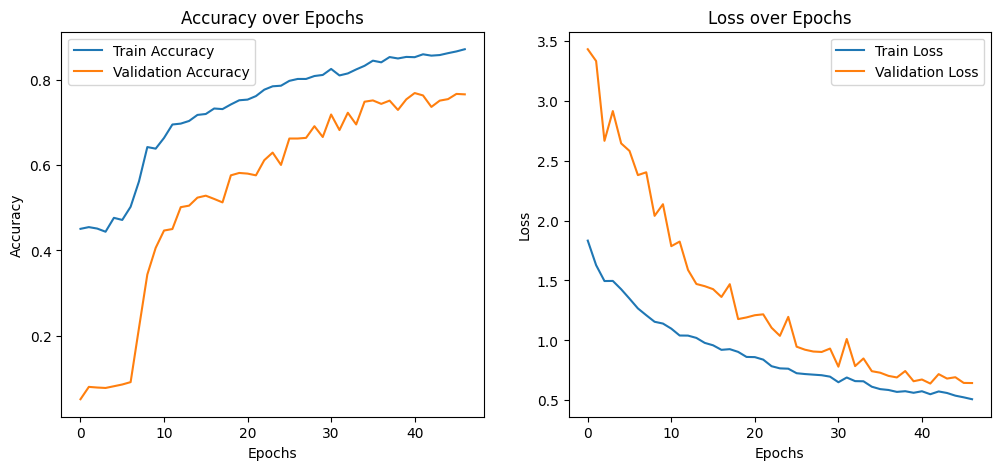

In [50]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

## 🧪 16. Test với Ảnh Mới


🎯 KẾT QUẢ PHÂN LOẠI

✅ Class dự đoán: Blackheads
📊 Độ tin cậy: 79.13%

------------------------------------------------------------
📈 TOP 3 DỰ ĐOÁN:
------------------------------------------------------------
1. Blackheads     :  79.13% ███████████████████████████████████████
2. Pustules       :  15.45% ███████
3. Scar           :   3.82% █



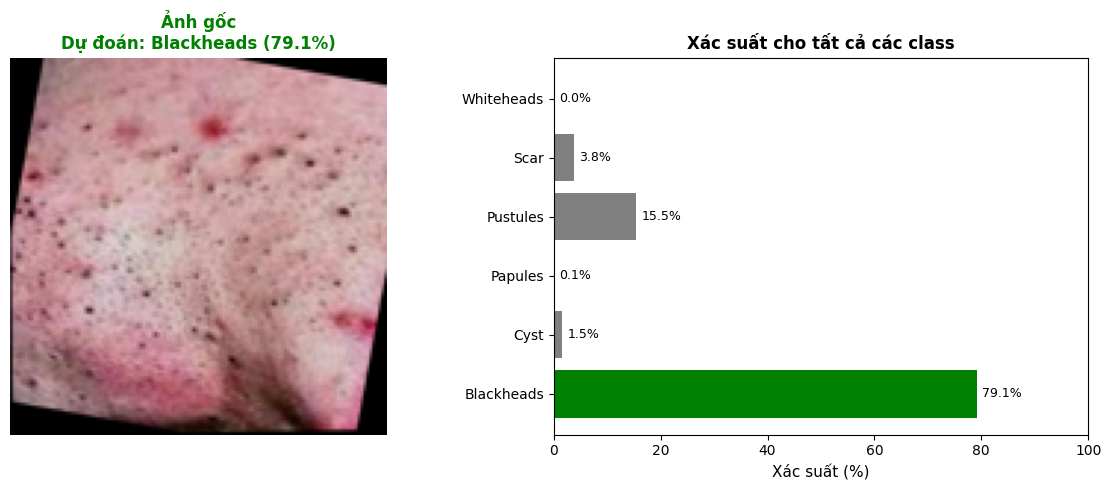

In [54]:
from PIL import Image
import numpy as np

# Đường dẫn đến ảnh cần test
image_path = "blackhead_22_jpg.rf.867831d071b19637db38f9c68ab90091.jpg"

# Load và preprocess ảnh
def load_and_preprocess_image(image_path, target_size=(IMAGE_SIZE, IMAGE_SIZE)):
    """
    Load và preprocess ảnh để predict
    """
    # Load ảnh
    img = Image.open(image_path)
    
    # Convert sang RGB nếu cần (tránh lỗi với ảnh RGBA hoặc grayscale)
    if img.mode != 'RGB':
        img = img.convert('RGB')
    
    # Resize về kích thước model yêu cầu
    img = img.resize(target_size)
    
    # Convert sang numpy array và normalize về [0, 1]
    img_array = np.array(img) / 255.0
    
    # Thêm batch dimension: (1, height, width, channels)
    img_array = np.expand_dims(img_array, axis=0)
    
    return img_array, img

# Load và preprocess ảnh
img_array, original_img = load_and_preprocess_image(image_path)

# Predict với model
predictions = model.predict(img_array, verbose=0)

# Lấy class có xác suất cao nhất
predicted_class_idx = np.argmax(predictions[0])
predicted_class_name = class_names[predicted_class_idx]
confidence = predictions[0][predicted_class_idx] * 100

# Lấy top 3 predictions
top_3_indices = np.argsort(predictions[0])[-3:][::-1]
top_3_classes = [class_names[i] for i in top_3_indices]
top_3_confidences = [predictions[0][i] * 100 for i in top_3_indices]

print("=" * 60)
print("🎯 KẾT QUẢ PHÂN LOẠI")
print("=" * 60)
print(f"\n✅ Class dự đoán: {predicted_class_name}")
print(f"📊 Độ tin cậy: {confidence:.2f}%")
print("\n" + "-" * 60)
print("📈 TOP 3 DỰ ĐOÁN:")
print("-" * 60)
for i, (cls, conf) in enumerate(zip(top_3_classes, top_3_confidences), 1):
    bar_length = int(conf / 2)  # Scale bar để hiển thị
    bar = "█" * bar_length
    print(f"{i}. {cls:15s}: {conf:6.2f}% {bar}")

print("\n" + "=" * 60)

# Hiển thị ảnh với kết quả
plt.figure(figsize=(12, 5))

# Ảnh gốc
plt.subplot(1, 2, 1)
plt.imshow(original_img)
plt.title(f"Ảnh gốc\nDự đoán: {predicted_class_name} ({confidence:.1f}%)", 
          fontsize=12, fontweight='bold', color='green' if confidence > 50 else 'orange')
plt.axis('off')

# Bar chart của predictions
plt.subplot(1, 2, 2)
colors = ['green' if i == predicted_class_idx else 'gray' for i in range(len(class_names))]
bars = plt.barh(class_names, predictions[0] * 100, color=colors)
plt.xlabel('Xác suất (%)', fontsize=11)
plt.title('Xác suất cho tất cả các class', fontsize=12, fontweight='bold')
plt.xlim(0, 100)

# Thêm giá trị trên mỗi bar
for i, (bar, prob) in enumerate(zip(bars, predictions[0] * 100)):
    plt.text(prob + 1, i, f'{prob:.1f}%', va='center', fontsize=9)

plt.tight_layout()
plt.show()

